# Задача 

Нужно проверить точность разных моделей на одном датасете кошек и собак

## Импорт данных 

In [1]:
import os
import numpy as np
import tensorflow as tf

In [2]:
path_to_training_data = os.path.join('data/train')
path_to_validation_data = os.path.join('data/validation')
path_to_test_data = os.path.join('data/test')

path_to_training_cat_data = os.path.join('data/train/cat')
path_to_training_dog_data = os.path.join('data/train/dog')
path_to_validation_cat_data = os.path.join('data/validation/cat')
path_to_validation_dog_data = os.path.join('data/validation/dog')

In [3]:
list_of_training_cat_data = os.listdir(path_to_training_cat_data)
list_of_training_dog_data = os.listdir(path_to_training_dog_data)
list_of_validation_cat_data = os.listdir(path_to_validation_cat_data)
list_of_validation_dog_data = os.listdir(path_to_validation_dog_data)
list_of_test_data = os.listdir(path_to_test_data)

In [4]:
print("Cat training data length: ", len(list_of_training_cat_data))
print("Dog training data length: ", len(list_of_training_dog_data))
print("Cat validation data length: ", len(list_of_validation_cat_data))
print("Dog validation data length: ", len(list_of_validation_dog_data))
print("Test data length: ", len(list_of_test_data))

Cat training data length:  7999
Dog training data length:  7999
Cat validation data length:  2001
Dog validation data length:  2001
Test data length:  2


## Визуализация данных 

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import random
from tensorflow import keras

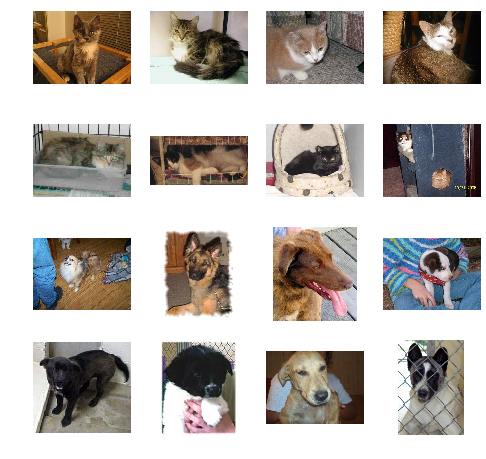

In [6]:
nrows = 4
ncols = 4

random.shuffle(list_of_training_cat_data)
random.shuffle(list_of_training_dog_data)

fig = plt.gcf()
fig.set_size_inches(nrows * 2, ncols * 2)

list_of_paths_to_training_cat_data = [os.path.join(path_to_training_cat_data, fname) 
                                        for fname in list_of_training_cat_data[:8]]
list_of_paths_to_training_dog_data = [os.path.join(path_to_training_dog_data, fname) 
                                        for fname in list_of_training_dog_data[:8]]

for i, path in enumerate(list_of_paths_to_training_cat_data + list_of_paths_to_training_dog_data):
    plt.subplot(nrows, ncols, i + 1)
    plt.axis('Off')
    pic = img.imread(path)
    plt.imshow(pic)
plt.show()

## Вспомогательные методы 

In [7]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc')>0.9):
            print('\nReached accuracy of 90.0%, stop training!')
            self.model.stop_training = True
myCallback = MyCallback()

Метод для оценки параметров модели.

In [8]:
def AccRecPrec(predictions, test_labels):
    #define the method
    x = tf.placeholder(tf.int32, )
    y = tf.placeholder(tf.int32, )
    acc, acc_op = tf.metrics.accuracy(labels=x, predictions=y)
    rec, rec_op = tf.metrics.recall(labels=x, predictions=y)
    pre, pre_op = tf.metrics.precision(labels=x, predictions=y)
    f1,  f1_op  = tf.contrib.metrics.f1_score(labels=x, predictions=y)

    def f(x):
        if (x>0.5):
            return 1
        else:
            return 0
        
    #predict the class using your classifier
    predictions = np.array(list(map(f, predictions)))

    #run the session to compare the label with the prediction
    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    v = sess.run(acc_op, feed_dict={x: test_labels,y: predictions}) #accuracy
    r = sess.run(rec_op, feed_dict={x: test_labels,y: predictions}) #recall
    p = sess.run(pre_op, feed_dict={x: test_labels,y: predictions}) #precision
    f = sess.run(f1_op,  feed_dict={x: test_labels,y: predictions}) #f1

    print("accuracy: ", v)
    print("recall:   ", r)
    print("precision:", p)
    print("f1:       ", 2*p*r/(p+r))

Подготовка картинок.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size = (150, 150),
        batch_size = 6,
        class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size = (150, 150),
        batch_size = 1,
        class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size = (150, 150),
        batch_size = 6,
        shuffle=False,
        class_mode = "binary"
)

Found 15998 images belonging to 2 classes.
Found 4002 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


Методы для отрисовки результата.

In [10]:
def loss(history_dict):
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [11]:
def acc(history_dict):
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
   
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Модель №1 

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0         
__________

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=6,  
      epochs=15,
      validation_data = validation_generator,
      validation_steps = 4)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
  19/2667 [..............................] - ETA: 8:09 - loss: 1.0594 - acc: 0.4912

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


1549/2667 [================>.............] - ETA: 3:29 - loss: 0.6365 - acc: 0.6471

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffIma

2125/2667 [======================>.......] - ETA: 1:37 - loss: 0.6279 - acc: 0.6586

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\

 565/4002 [===>..........................] - ETA: 5:05 - loss: 0.6340 - acc: 0.7009

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: Us

1773/4002 [============>.................] - ETA: 2:19 - loss: 0.5791 - acc: 0.7208

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\

2667/2667 [==============================] - 725s 272ms/step - loss: 0.6142 - acc: 0.6726 - val_loss: 0.5836 - val_acc: 0.7194
Epoch 2/15
2667/2667 [==============================] - 592s 222ms/step - loss: 0.5305 - acc: 0.7490 - val_loss: 0.5552 - val_acc: 0.7289
Epoch 3/15
2667/2667 [==============================] - 597s 224ms/step - loss: 0.4986 - acc: 0.7738 - val_loss: 0.4883 - val_acc: 0.8058
Epoch 4/15
2667/2667 [==============================] - 643s 241ms/step - loss: 0.4886 - acc: 0.7877 - val_loss: 0.4872 - val_acc: 0.7754
Epoch 5/15
2667/2667 [==============================] - 590s 221ms/step - loss: 0.4909 - acc: 0.7933 - val_loss: 0.4550 - val_acc: 0.8063
Epoch 6/15
2667/2667 [==============================] - 589s 221ms/step - loss: 0.4818 - acc: 0.7947 - val_loss: 1.6222 - val_acc: 0.6672
Epoch 7/15
2667/2667 [==============================] - 595s 223ms/step - loss: 0.4830 - acc: 0.7949 - val_loss: 0.8474 - val_acc: 0.7196
Epoch 8/15
2667/2667 [=======================

### Результаты 

In [17]:
history_dict = history.history

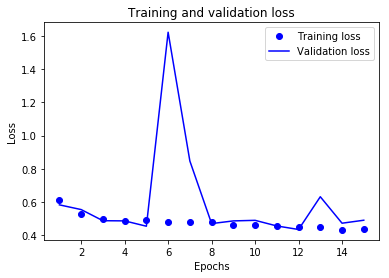

In [18]:
loss(history_dict)

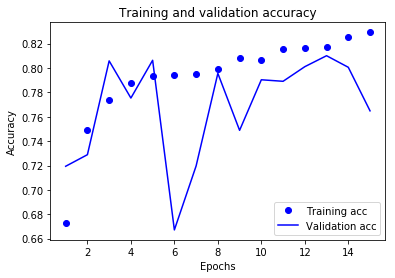

In [19]:
acc(history_dict)

In [20]:
predictions = model.predict_generator(test_generator)

D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
D:\Programms\Anaconda3\envs\tf_gpu\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF d

In [22]:
AccRecPrec(predictions, test_generator.classes)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

accuracy:  0.7543017
recall:    0.59183675
precision: 0.8767042
f1:        0.7066412272419291


###  Сохраним результаты

In [42]:
model.save('models/3convolutions.h5')

In [41]:
saved_model_path = "models/pbmodel/"
tf.contrib.saved_model.save_keras_model(model, saved_model_path)


Consider using a TensorFlow optimizer from `tf.train`.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/pbmodel/1563193257\saved_model.pb


b'models/pbmodel/1563193257'

## Модель №2 

In [37]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [38]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 17,280,513
Trainable params: 17,280,513
Non-trainable params: 0
_________________________________________________________________


In [39]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit_generator(
      train_generator,
      steps_per_epoch=6,  
      epochs=15,
      validation_data = validation_generator,
      validation_steps = 4)